### summary

Code for evaluating the manual detections perfromed by a lab technician

This code mirrors 03_evaluation_and_optimization


In [ ]:


#imports 
import os
import fiftyone as fo
from fiftyone import ViewField as F
import yaml

# first check the wd is not notebooks but the main folder
print("cwd is", os.getcwd())

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("cwd changed to", os.getcwd())


# set paths
# -------------------------------------------------------------------------------------------------------------------- #
gt_directory = "datasets/testset/groundtruth_testset"       
manualcount_directory = "datasets/manual_ortho_count/boundingboxes"     
# -------------------------------------------------------------------------------------------------------------------- #





cwd is /home/tmueller/github/AIggregation


In [ ]:

# rename label studio outputs to have same name as fiftyone outputs (label studio adds long numeric strings upon export)
for root, dirs, files in os.walk(manualcount_directory):
    for file in files:
        oldname = os.path.join(root,file)
        if "-" in file:
            newname = file.split("-")[1]
            os.rename(oldname, os.path.join(root,newname))


# create a YAML file in the manual count folder 
folder = manualcount_directory.split('/')[-1] # get end of string (folder name)

data = {
    'names':{
    0: "nest"},
    'path': os.path.join("..", folder),
    'val': "./images/"
        }
with open((os.path.join(manualcount_directory,"dataset.yaml")), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False, sort_keys=False)




In [13]:

# import manual count tiles into fiftyone
datasettest = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = os.path.join(manualcount_directory, "dataset.yaml"),
    label_field= "manual_count"
)

# import groundtruthed tiles into fiftyone
dataset_ground = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = os.path.join(gt_directory,"dataset.yaml"),
    label_field= "ground_truth"
)

# merge the datasets, merging images/labels with the same file name
key_fcn = lambda sample: os.path.basename(sample.filepath)

datasettest.merge_samples(dataset_ground, key_fcn=key_fcn)



# delete any oblong box predictions
# these are created by splitting tiles through the middle of an existing bounding box. Nest predictions should not be oblong

# Compute the dimensions of each bounding box in pixels
box_width, box_height = F("bounding_box")[2], F("bounding_box")[3]

# remove detections where one side of the box is greater than 2.5 time the other
def get_label_fields(sample_collection):
    """Get the (detection) label fields of a Dataset or DatasetView."""
    label_fields = list(
        sample_collection.get_field_schema(embedded_doc_type=fo.Detections).keys()
    )
    return label_fields


for lf in get_label_fields(datasettest):
    datasettest_temp = datasettest.filter_labels(
    "manual_count", (box_height < (box_width*2)) & (box_width < (box_height*2)), only_matches=False)


for lf in get_label_fields(datasettest_temp):
    datasettest_keep = datasettest_temp.filter_labels(
    "ground_truth", (box_height < (box_width*2)) & (box_width < (box_height*2)), only_matches=False)




 100% |█████████████████| 365/365 [412.8ms elapsed, 0s remaining, 888.4 samples/s]      
 100% |█████████████████| 365/365 [276.0ms elapsed, 0s remaining, 1.3K samples/s]     
Indexing dataset...
 100% |█████████████████| 365/365 [120.1ms elapsed, 0s remaining, 3.0K samples/s]     
Merging samples...
 365 [706.4ms elapsed, ? remaining, 517.7 samples/s] 


In [ ]:
# set parameters
# -------------------------------------------------------------------------------------------------------------------- #
prediction = "manual_count"         # prediction name
gt = "ground_truth"                 # ground truth name
iou = 0.4                           # what IOU to use for FN and FP detections
# -------------------------------------------------------------------------------------------------------------------- #


# Evaluate the objects in the `predictions` field with respect to the
# objects in the `ground_truth` field
results = datasettest_keep.evaluate_detections(
    prediction,
    gt_field=gt,
    eval_key="eval",
    missing = "fn",
    iou=iou
)

results.print_report()



Evaluating detections...
 100% |█████████████████| 365/365 [801.4ms elapsed, 0s remaining, 455.4 samples/s]      
              precision    recall  f1-score   support

        nest       0.89      0.90      0.90       521

   micro avg       0.89      0.90      0.90       521
   macro avg       0.89      0.90      0.90       521
weighted avg       0.89      0.90      0.90       521




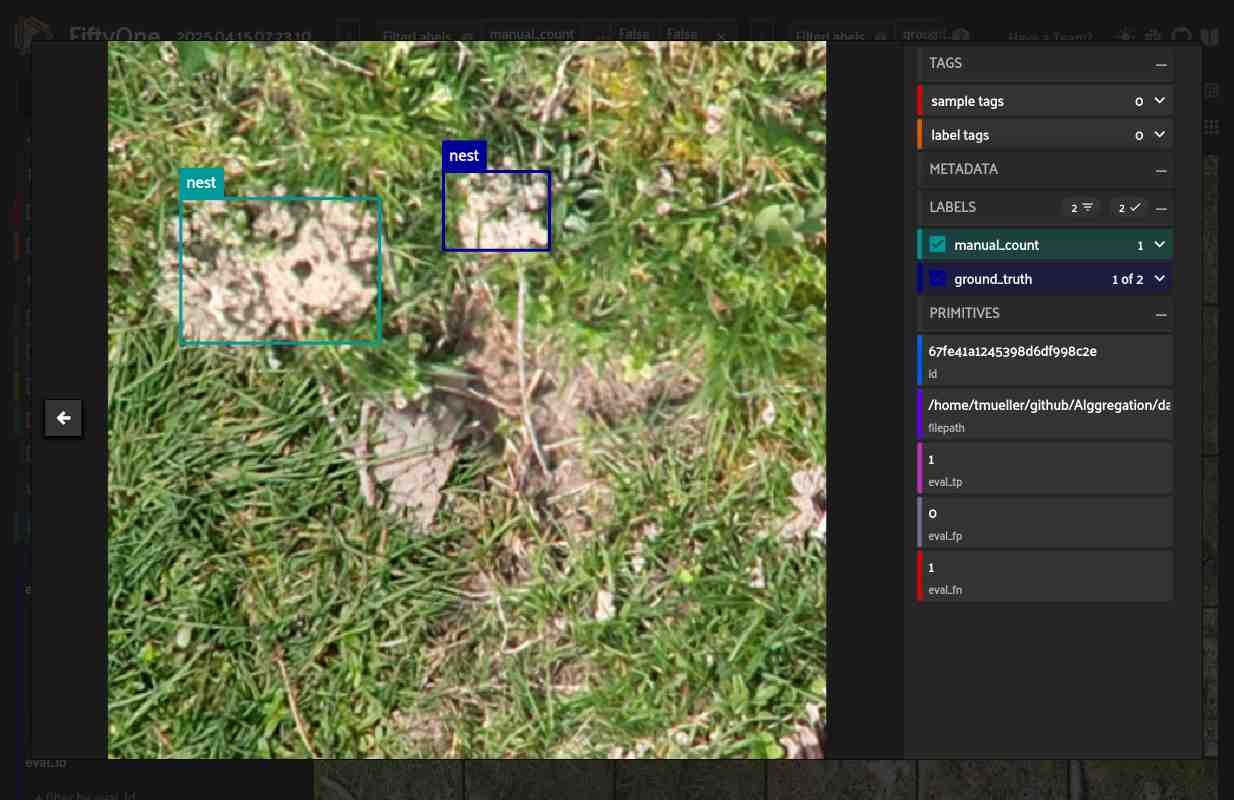

In [10]:

session = fo.launch_app(datasettest_keep)

